In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pylab as p
import seaborn as sns
from scipy import stats
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.decomposition import PCA

# Налаштування стилю для графіків
sns.set(style="whitegrid")

print('[+] Налаштування завершено')

[+] Налаштування завершено


In [2]:
def load_data(file_path: str) -> pd.DataFrame:
    """
    Завантажує датасет з вказаного шляху.

    :param file_path: Шлях до CSV файлу датасету.
    :return: DataFrame з завантаженими даними.
    """
    try:
        df = pd.read_csv(file_path)
        print("[+] Дані успішно завантажені.")
        return df
    except FileNotFoundError:
        print(f"[!] Файл за шляхом {file_path} не знайдено.")
        raise

In [3]:
DATA_FILE: str = '../../lab02/source/final.csv'
DATAFRAME: pd.DataFrame = load_data(DATA_FILE)

[+] Дані успішно завантажені.


In [4]:
numerical_cols = DATAFRAME.select_dtypes(include=[np.number]).columns.tolist()
print(f"Числові стовпці: {numerical_cols}")

Числові стовпці: ['Port Code', 'Value']


In [5]:
scaler = StandardScaler()

In [6]:
SCALED_DF = scaler.fit_transform(DATAFRAME[numerical_cols])
SCALED_DF = pd.DataFrame(SCALED_DF, columns=numerical_cols)
SCALED_DF

,Port Code,Value
0,-0.513979,-0.430003
1,0.651537,0.381686
2,-0.945381,0.998635
3,0.528697,-0.288448
4,0.655924,-0.002884
...,...,...
238651,0.658848,0.425052
238652,0.512611,-0.480733
238653,0.672010,-0.480733
238654,-0.655830,-0.480733


## Кластеризація

In [7]:
def elbow_method(data: pd.DataFrame, max_k: int = 10) -> None:
    """
    Perform the elbow method to determine the optimal number of clusters
    
    :param data: Scaled DataFrame
    :param max_k: Maximum number of clusters
    """
    sse = []
    k_range = range(1, max_k + 1)
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(data)
        sse.append(kmeans.inertia_)

    plt.figure(figsize=(10, 6))
    plt.plot(k_range, sse, marker='o')
    plt.title('Метод Ліктя')
    plt.xlabel('Кількість Кластерів (k)')
    plt.ylabel('Сума Квадратів Відхилень (SSE)')
    plt.xticks(k_range)
    plt.grid(True)

    plt.savefig('elbow_method.png')
    plt.show()

C:\Users\m1ken\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\m1ken\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


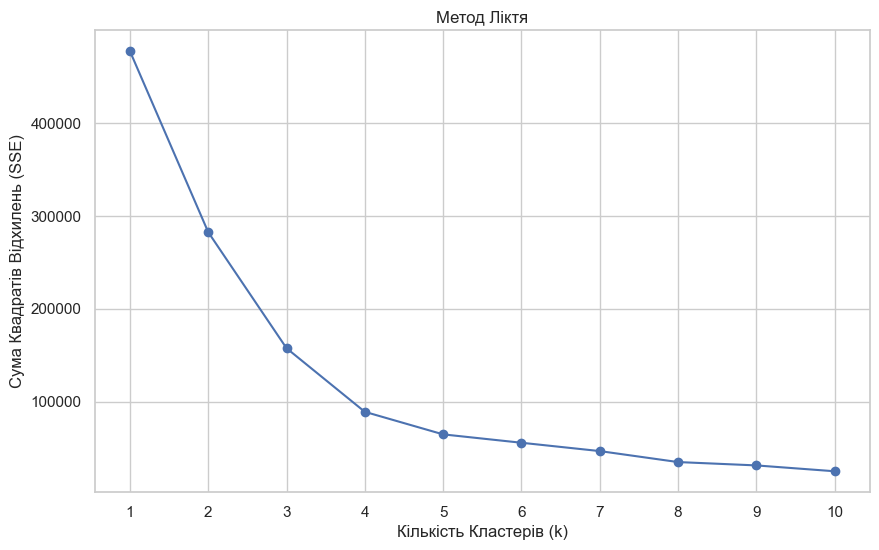

In [8]:
elbow_method(SCALED_DF, max_k=10)

In [9]:
OPTIMAL_K: int = 4

In [10]:
# Ініціалізація та тренування моделі к-середніх
kmeans = KMeans(n_clusters=OPTIMAL_K, random_state=42)
kmeans.fit(SCALED_DF)

KMeans(n_clusters=4, random_state=42)

In [11]:
DATAFRAME['KMeans_Cluster'] = kmeans.labels_
DATAFRAME

,Port Name,State,Port Code,Border,Date,Measure,Value,Location,KMeans_Cluster
0,Nogales,Arizona,2604,US-Mexico Border,03/01/2019 12:00:00 AM,Trains,-0.430002,POINT (-110.93361 31.340279999999996),1
1,Pembina,North Dakota,3401,US-Canada Border,03/01/2019 12:00:00 AM,Bus Passengers,0.381685,POINT (-97.24333 48.96639),0
2,Progreso,Texas,2309,US-Mexico Border,03/01/2019 12:00:00 AM,Truck Containers Empty,0.998633,POINT (-97.94889 26.061670000000003),1
3,Opheim,Montana,3317,US-Canada Border,03/01/2019 12:00:00 AM,Personal Vehicles,-0.288447,POINT (-106.40265 48.85574),0
4,Neche,North Dakota,3404,US-Canada Border,03/01/2019 12:00:00 AM,Trucks,-0.002884,POINT (-97.55444 48.98611),0
...,...,...,...,...,...,...,...,...,...
238651,Northgate,North Dakota,3406,US-Canada Border,01/01/1996 12:00:00 AM,Trucks,0.425051,POINT (-102.27 49),0
238652,Turner,Montana,3306,US-Canada Border,01/01/1996 12:00:00 AM,Rail Containers Empty,-0.480732,POINT (-108.39 49),0
238653,Hansboro,North Dakota,3415,US-Canada Border,01/01/1996 12:00:00 AM,Rail Containers Full,-0.480732,POINT (-99.35 49),0
238654,Calexico East,California,2507,US-Mexico Border,01/01/1996 12:00:00 AM,Buses,-0.480732,POINT (-115.39 32.67),1


### Надати таблицю з цетрами кластерів та кількістю елементів;

In [12]:
# Отримання центрів кластерів
cluster_centers = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=numerical_cols)

# Додавання номера кластера
cluster_centers.index = [f'Кластер {i}' for i in range(OPTIMAL_K)]

# Підрахунок кількості елементів в кожному кластері
cluster_counts = DATAFRAME['KMeans_Cluster'].value_counts().sort_index()
cluster_summary = pd.concat([cluster_centers, cluster_counts.rename('Кількість Елементів')], axis=1)

cluster_summary

,Port Code,Value,Кількість Елементів
Кластер 0,3296.003862,-0.310328,NaN
Кластер 1,2456.804587,-0.282835,NaN
Кластер 2,2975.794927,2.660119,NaN
Кластер 3,723.524074,0.151293,NaN
0,NaN,NaN,156619.0
1,NaN,NaN,45775.0
2,NaN,NaN,22384.0
3,NaN,NaN,13878.0


### Візуалізація кластерів

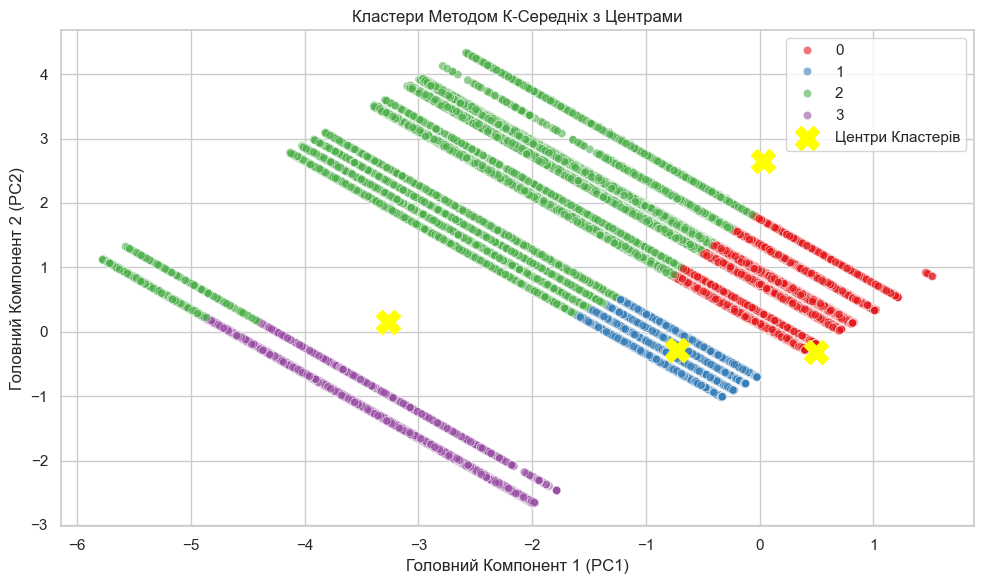

In [13]:
pca = PCA(n_components=2, random_state=42)
principal_components = pca.fit_transform(SCALED_DF)

# Створення DataFrame з компонентами та кластерами
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['Cluster'] = kmeans.labels_

# Візуалізація
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Cluster', palette='Set1', alpha=0.6)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
            s=300, c='yellow', label='Центри Кластерів', marker='X'
            )
plt.title('Кластери Методом К-Середніх з Центрами')
plt.xlabel('Головний Компонент 1 (PC1)')
plt.ylabel('Головний Компонент 2 (PC2)')
plt.legend()
plt.tight_layout()
plt.savefig('kmeans_clusters.png')
plt.show()

In [14]:
def plot_dendrogram(data: pd.DataFrame) -> None:
    """
    Будує дендограму для ієрархічного кластерного аналізу.
    
    :param data: Масштабований DataFrame.
    """
    linked = linkage(data, method='ward')

    plt.figure(figsize=(15, 7))
    dendrogram(linked,
               truncate_mode='lastp',  # показує тільки останні p кластерів
               p=50,  # кількість останніх кластерів
               leaf_rotation=90.,
               leaf_font_size=12.,
               show_contracted=True
               )
    plt.title('Дендограма Ієрархічного Кластерного Аналізу')
    plt.xlabel('Кількість Кластерів')
    plt.ylabel('Відстань')
    plt.tight_layout()
    plt.savefig('dendrogram.png')
    plt.show()

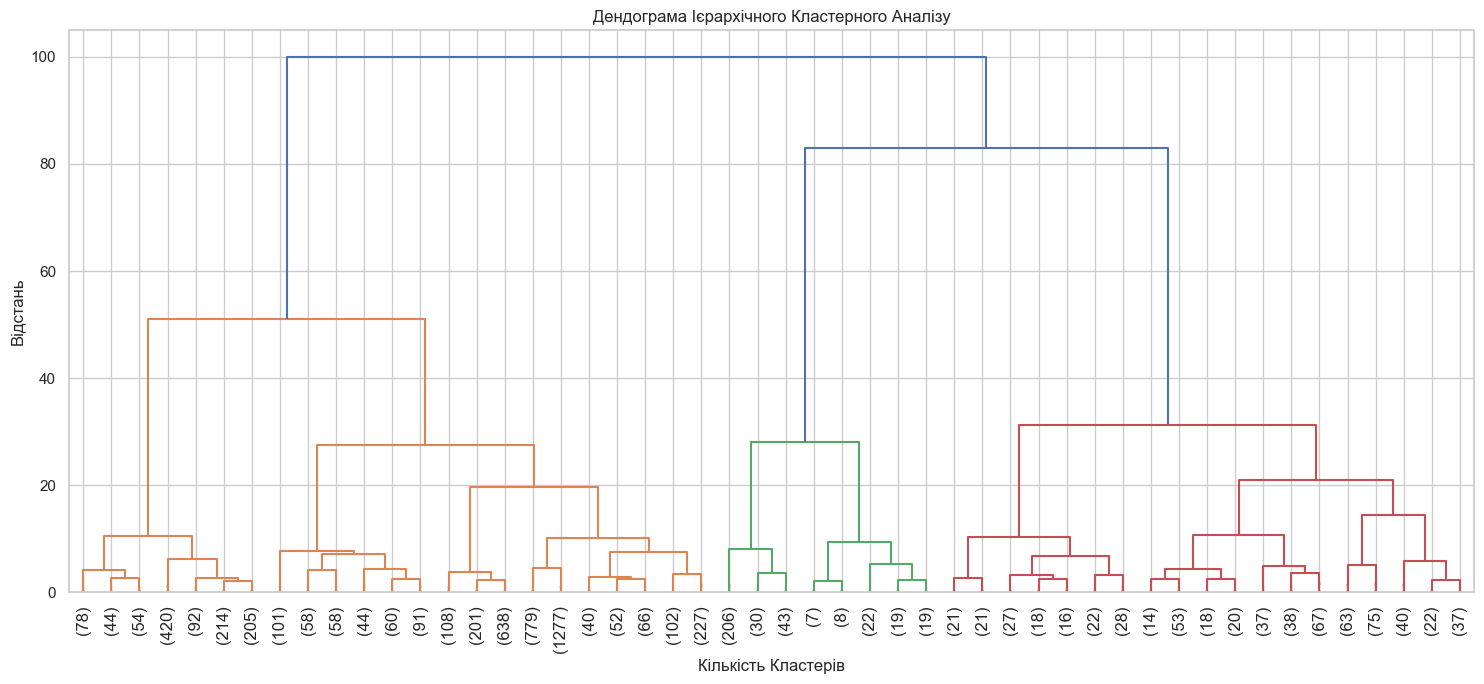

In [15]:
SAMPLE_SCALED_DF = SCALED_DF.sample(n=6000, random_state=42)
plot_dendrogram(SAMPLE_SCALED_DF)

In [16]:
SAMPLE_DF = DATAFRAME.sample(n=6000, random_state=42)

In [17]:
hierarchical = AgglomerativeClustering(n_clusters=OPTIMAL_K, linkage='ward')
SAMPLE_DF['Hierarchical_Cluster'] = hierarchical.fit_predict(SAMPLE_SCALED_DF)

In [18]:
SAMPLE_DF

,Port Name,State,Port Code,Border,Date,Measure,Value,Location,KMeans_Cluster,Hierarchical_Cluster
176943,Detroit,Michigan,3801,US-Canada Border,12/01/2001 12:00:00 AM,Buses,1.708040,POINT (-83.04 42.32),2,0
68898,Ambrose,North Dakota,3410,US-Canada Border,10/01/2011 12:00:00 AM,Trucks,-0.480732,POINT (-103.49 49),0,1
209313,Nogales,Arizona,2604,US-Mexico Border,10/01/1998 12:00:00 AM,Rail Containers Empty,0.798166,POINT (-110.94 31.33),1,0
69667,Lukeville,Arizona,2602,US-Mexico Border,09/01/2011 12:00:00 AM,Truck Containers Full,-0.480732,POINT (-112.82 31.880000000000003),1,3
99579,Progreso,Texas,2309,US-Mexico Border,01/01/2009 12:00:00 AM,Train Passengers,-0.480732,POINT (-97.95 26.06),1,3
...,...,...,...,...,...,...,...,...,...,...
189625,Champlain-Rouses Point,New York,712,US-Canada Border,09/01/2000 12:00:00 AM,Train Passengers,0.886535,POINT (-73.45 45.01),3,2
35614,Roma,Texas,2310,US-Mexico Border,10/01/2014 12:00:00 AM,Rail Containers Full,-0.480732,POINT (-99.02 26.4),1,3
137952,Noyes,Minnesota,3402,US-Canada Border,08/01/2005 12:00:00 AM,Trains,-0.415274,POINT (-97.21 49),0,1
184157,Trout River,New York,715,US-Canada Border,04/01/2001 12:00:00 AM,Rail Containers Empty,-0.315449,POINT (-74.31 44.99),3,2


In [19]:
hierarchical_counts = SAMPLE_DF['Hierarchical_Cluster'].value_counts().sort_index()
hierarchical_summary = pd.DataFrame({
    'Кластер': [f'Кластер {i}' for i in range(OPTIMAL_K)],
    'Кількість Елементів': hierarchical_counts.values
})

hierarchical_summary

,Кластер,Кількість Елементів
0,Кластер 0,637
1,Кластер 1,3902
2,Кластер 2,354
3,Кластер 3,1107


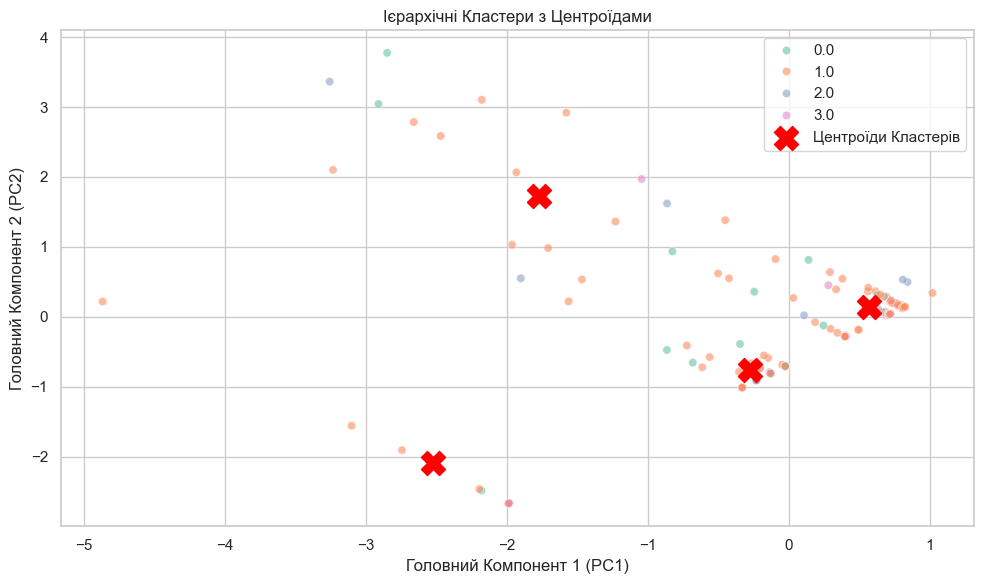

In [20]:
hierarchical_centroids = SAMPLE_DF.groupby('Hierarchical_Cluster')[numerical_cols].mean()
hierarchical_centroids = pd.DataFrame(scaler.transform(hierarchical_centroids), columns=numerical_cols)

# Застосування PCA для зменшення вимірності
principal_components = pca.transform(SAMPLE_SCALED_DF)
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['Hierarchical_Cluster'] = SAMPLE_DF['Hierarchical_Cluster']

# Обчислення PCA-компонент для центроїдів
hierarchical_centroids_pca = pca.transform(hierarchical_centroids)
hierarchical_centroids_pca_df = pd.DataFrame(data=hierarchical_centroids_pca, columns=['PC1', 'PC2'])
hierarchical_centroids_pca_df['Cluster'] = [f'Кластер {i}' for i in range(OPTIMAL_K)]

# Візуалізація
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Hierarchical_Cluster', palette='Set2', alpha=0.6)
plt.scatter(hierarchical_centroids_pca_df['PC1'], hierarchical_centroids_pca_df['PC2'],
            s=300, c='red', label='Центроїди Кластерів', marker='X'
            )
plt.title('Ієрархічні Кластери з Центроїдами')
plt.xlabel('Головний Компонент 1 (PC1)')
plt.ylabel('Головний Компонент 2 (PC2)')
plt.legend()
plt.tight_layout()
plt.savefig('hierarchical_clusters.png')
plt.show()

In [21]:
comparison = pd.DataFrame({
    'Кластер К-Середніх': SAMPLE_DF['KMeans_Cluster'].value_counts().sort_index(),
    'Кластер Ієрархічного': SAMPLE_DF['Hierarchical_Cluster'].value_counts().sort_index()
})

comparison

,Кластер К-Середніх,Кластер Ієрархічного
0,3886,637
1,1177,3902
2,592,354
3,345,1107


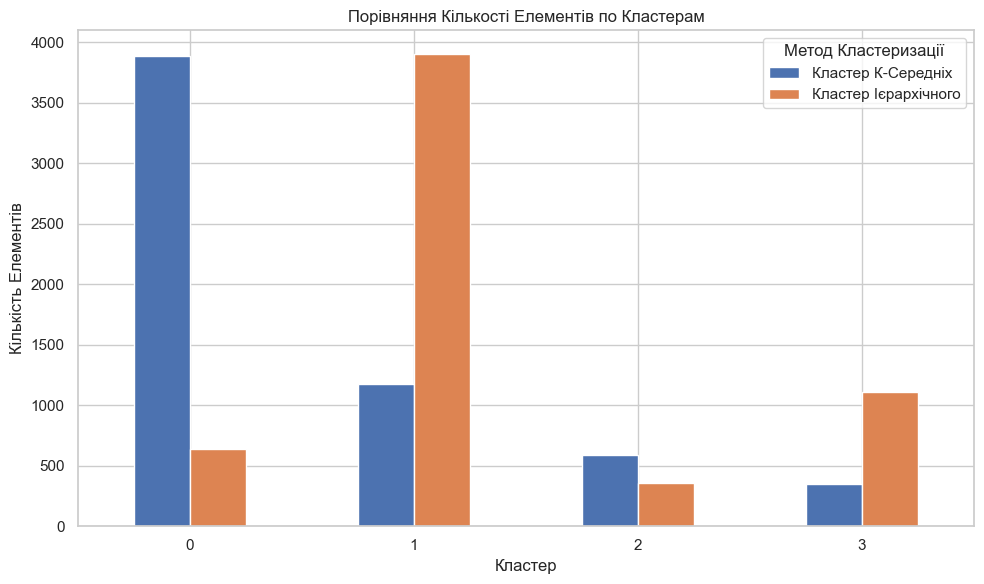

In [22]:
comparison.plot(kind='bar', figsize=(10, 6))
plt.title('Порівняння Кількості Елементів по Кластерам')
plt.xlabel('Кластер')
plt.ylabel('Кількість Елементів')
plt.xticks(rotation=0)
plt.legend(title='Метод Кластеризації')
plt.tight_layout()
plt.savefig('cluster_comparison.png')
plt.show()